In [1]:
from collections import Counter
import cv2
from glob import glob
from IPython.display import Audio
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, det_curve, roc_auc_score, auc, precision_score, recall_score, f1_score, classification_report
from sklearn import tree
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from time import process_time

In [2]:
#Settings and Parameters
# Data path:
data_path = "data-all"
speakers_path = "SPEAKERS.TXT"

win_size: 1024
hop_size: 512
n_mels: 12
n_dct: 20
sample_rate = 32000
off_set = 0
duration = 5.0

# If you decide to use batch sizes:
batch_size = 1000

sample_size = (round((sample_rate*duration)), 1)

feats_label = [ 'ID', 'GENDER', 'SPEC_1', 'SPEC_2', 'SPEC_3', 'SPEC_4', 
                'SPEC_5', 'SPEC_6', 'SPEC_7', 'SPEC_8', 
                'SPEC_9', 'SPEC_10', 'SPEC_11', 'SPEC_12', 
                'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4',
                'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
                'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
                'MFCCD_1', 'MFCCD_2', 'MFCCD_3', 'MFCCD_4',
                'MFCCD_5', 'MFCCD_6', 'MFCCD_7', 'MFCCD_8',
                'MFCCD_9', 'MFCCD_10', 'MFCCD_11', 'MFCCD_12',
                'PCEN_1', 'PCEN_2', 'PCEN_3', 'PCEN_4', 
                'PCEN_5', 'PCEN_6', 'PCEN_7', 'PCEN_8', 
                'PCEN_9', 'PCEN_10', 'PCEN_11', 'PCEN_12']
feats = ['SPECTROGRAM', 'MFCC', 'MFCC DELTA2', 'PCEN']
feats = ['SPECTROGRAM', 'MFCC', 'MFCC DELTA2', 'PCEN']
coeffs = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

In [3]:
#Helper Functions
def extract_id_sex():
    id_sex_array = []
    with open(speakers_path, 'r') as file:
        # Skip the header line
        for line in file:
            if( line.startswith( ";" ) ):
                continue;
            else:
                columns = line.split('|')
                # Extract the ID and SEX
                id_value = columns[0].strip()
                sex_value = columns[1].strip()
                # Append ID and SEX to the array
                id_sex_array.append((id_value, sex_value))
                
    return id_sex_array

def load_directory():
    # Find all samples in the directory
    files = glob(os.path.join(data_path, '*.flac'))
    # The audio data
    x = []
    # The gender and speaker ID
    y = []

    # Create a dictionary for speaker genders
    speaker_gender_dict = {speaker[0]: speaker[1] for speaker in speaker_gender}

    counter_f = 0
    counter_m = 0
    speakers = []

    if batch_size > len(files):
        error_msg = f'Requested a batch size greater than the number of samples available ({len(files)})'
        raise ValueError(error_msg)

    for file in files:
        if (len(x) == batch_size):
            break
        
        # Collect the speaker IDs, because we are classifying on gender the speakerID does not 
        # matter as a label, but it does help us ensure we have a diverse representation of 
        # speakers for each gender, so we will only take 1 sample per speaker for each gender.
        fileName = file.split('\\')[1]
        speakerId = fileName.split('-')[0]

        # Due to limited number of samples per speaker limit the below code to 14500
        if batch_size < 14500:
            # extract an even number of samples from each speaker ensuring we get a diverse
            # range of speakers 
            num_samples_per_speaker = round(batch_size / 250)
            speaker_count = Counter(speakers)
            if (speaker_count[speakerId] >= num_samples_per_speaker):
                continue
        
        # Use dictionary for faster search performance.
        gender = speaker_gender_dict.get(speakerId)

        if (gender == 'F' and (counter_f < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((0, speakerId))
            speakers.append(speakerId)
            counter_f = counter_f + 1

        elif (gender == 'M' and (counter_m < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((1, speakerId))
            speakers.append(speakerId)
            counter_m = counter_m + 1

    return np.array(x), np.array(y, dtype=int)

def plot_decision_boundary(classifier, ax, X, Y, title='', padding = 0.5):
    mins = np.min(X, 0) - padding
    print(mins.shape)
    print(mins[:3])
    maxs = np.max(X, 0) + padding
    print(maxs.shape)
    print(maxs[:3])
    xx, yy = np.meshgrid(np.arange(mins[0], maxs[0], 0.025),
                         np.arange(mins[1], maxs[1], 0.025))
    print(xx.shape)
    print(xx[:3])
    print((xx.ravel()).shape)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    ax.set_title(title)

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

def feature_extraction(audio):
        spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y=audio,
                                             sr=32000,
                                             n_mels=12,
                                             hop_length=512,
                                             power=2,
                                             n_fft=1024))

        mfcc = librosa.feature.mfcc(S=spectrogram, n_mfcc=12)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        pcen = librosa.pcen(librosa.feature.melspectrogram(y=audio, 
                                                        sr=32000,
                                                        n_fft=1024, 
                                                        hop_length=512, 
                                                        power=1, 
                                                        n_mels= 12))
        
        #Append and flatten
        raw_features = np.concatenate((spectrogram,mfcc,delta2_mfcc, pcen),axis=0)
        features = raw_features.ravel()
        #return features, spectrogram, mfcc, delta2_mfcc, pcen
        return features

In [4]:
speaker_gender = extract_id_sex()
x_data, y = load_directory()
# Information on the extracted audio data:
print(f'x data, first sample: {x_data[0]}')
print(f'shape x data: {x_data.shape}')

y_data = np.array([row[0] for row in y])
print("first 10 y data: " + str(y_data[:10]))
speakerIds = [row[1] for row in y]
print(f'shape y data: {y_data.shape}')

f_rows = y[y[:, 0] == 0]
m_rows = y[y[:, 0] == 1]
print()
print(f'Female Speakers - {len(np.unique(f_rows[:, 1]))} : {np.unique(f_rows)}')
print(f'Male Speakers - {len(np.unique(m_rows[:, 1]))}: {np.unique(m_rows)}')

x data, first sample: [-0.00629657 -0.00675512 -0.00572782 ... -0.01366212 -0.01157286
 -0.00571476]
shape x data: (1000, 160000)
first 10 y data: [0 0 0 0 1 1 1 1 1 1]
shape y data: (1000,)

Female Speakers - 125 : [   0   19   32   39   40   83   87   89  103  125  150  198  200  211
  226  248  250  289  298  302  322  328  403  426  441  587  669  696
  730  887 1069 1088 1098 1116 1183 1246 1263 1363 1447 1502 1553 1578
 1737 1841 1898 1926 1963 1970 1992 2007 2092 2182 2196 2391 2416 2691
 2764 2817 2836 2910 2989 3112 3235 3259 3440 3526 3879 3947 3982 3983
 4051 4088 4137 4160 4195 4214 4297 4340 4362 4481 4640 4680 4853 5022
 5163 5339 5393 5514 5561 5652 5688 5778 5789 5867 6000 6064 6078 6147
 6272 6385 6415 6476 6531 6818 7059 7078 7113 7148 7178 7302 7511 7517
 7635 7780 7794 7800 7859 8014 8051 8123 8238 8312 8324 8465 8468 8975]
Male Speakers - 125: [   1   26   27   60   78  118  163  196  201  229  233  254  307  311
  332  374  405  412  445  446  458  460  481  625  

In [5]:
feature_list = []
df = pd.DataFrame(columns = feats_label, index = y[:,1])


for file in x_data:
    feat = feature_extraction(file)
    feature_list.append(feat)
feature_list = np.array(feature_list)

In [6]:
x_data = feature_list

In [7]:
x_train, x_remain, y_train, y_remain = train_test_split(x_data, y_data, 
                                                        test_size=0.6, 
                                                        random_state=42, 
                                                        shuffle=True,
                                                        stratify=y_data)

x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                shuffle=True,
                                                stratify=y_remain)

In [8]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=None, max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
                oob_score=True, random_state=42, verbose=0,
                warm_start=False)

Random forest score: 0.7366666666666667
0.7350993377483444
0.74
F1 Score:
0.7375415282392026
Time taken to train:  4.90625


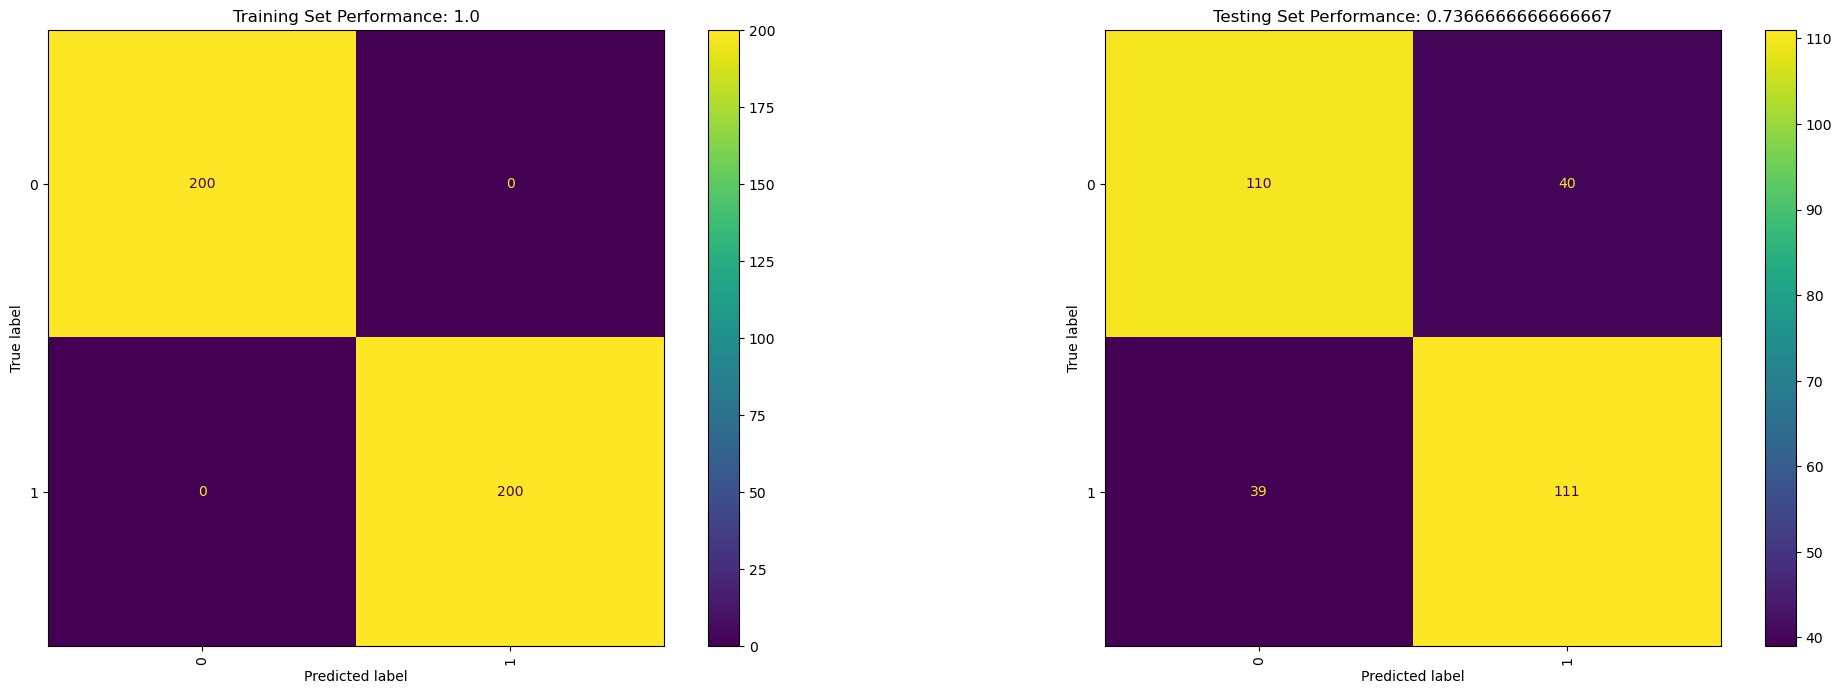

In [9]:
train_time_start = process_time()
rf.fit(x_train, y_train)
train_time_end = process_time()
print("Random forest score: {}".format(rf.score(x_test, y_test)))
print(precision_score(y_test, rf.predict(x_test),  pos_label=1))
print(recall_score(y_test, rf.predict(x_test),  pos_label=1))
print("F1 Score:")
print(f1_score(y_test, rf.predict(x_test),  pos_label=1))
time_taken = train_time_end - train_time_start
print(f'{"Time taken to train: "} {time_taken}')
eval_model(rf, x_train, y_train, x_test, y_test)